# Calculate single perturbation score per variant

We want one overall edgotyping score to make variant-level hit calls. Here we explore several strategies for this:

- call the variant "perturbed" if any edge is perturbed
- compute the fraction of perturbed edges and find some way to calibrate this score
- calculate the Euclidean distance between profiles and find some way to calibrate this score

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import os

In [2]:
outputs_dir = "../3_outputs/sqY2H"
meta_outputs = "../../../1_allele_collection/3_outputs"

In [7]:
# Calculate Euclidean distance for each variant relative to it's wildtype reference
orf_profiles = os.listdir(f"{outputs_dir}/edgotype_profiles")
zero_col = "0"
perturbed_thresh = 0.5 # edge called "perturbed" if >= 50% decrease compared to wt reference
orf_distances = []

wt_thresh = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

for orf in orf_profiles:
    profiles = pl.read_csv(f"{outputs_dir}/edgotype_profiles/{orf}")
    
    # filter out edges where the WT could not be measured
    profiles = profiles.filter(~pl.col("0").is_null())

    db_orf_id = orf.replace("orf_id_", "")
    db_orf_id = db_orf_id.replace(".csv", "")

    columns = [col for col in profiles.columns if col != "ad_orf_id"]

    # "impute" missing values as the mean for that variant
    profiles_filled = profiles.with_columns([
        pl.when(pl.col(col).is_null())
        .then(pl.col(col).mean())
        .otherwise(pl.col(col))
        .alias(col)
        for col in columns
    ])

    # compute distances
    distance_rows = []
    for col in columns:
        if col == zero_col:
            continue
        
        # Euclidean distance
        diff_squared = (profiles_filled[col] - profiles_filled[zero_col]) ** 2
        distances = np.sqrt(diff_squared.sum())

        # Cosine similarity
        wt = profiles_filled.select(zero_col).to_numpy()
        var = profiles_filled.select(col).to_numpy()

        if wt.ndim == 1:
            wt = wt.reshape(-1, 1)
        if var.ndim == 1:
            var = var.reshape(-1, 1)
        cos_sim = cosine_similarity(wt.T, var.T)
        cos_dist = 1 - cos_sim

        # calculate frac perturbed
        wt_pass = []
        per_edges = []
        for thresh in wt_thresh:
            filt_wt = profiles.filter(pl.col("0") > thresh)
            wt_pass.append(filt_wt.shape[0])
            per_edges.append(filt_wt.filter((pl.col(col)/pl.col("0")) <= perturbed_thresh).shape[0])            

        distance_rows.append({
            "db_orf_id": db_orf_id,
            "db_mut_id": int(col),
            "euclid_distance": distances,
            "cosine_distance": cos_dist,
            "num_edges": profiles.shape[0],
            "num_zero_wt": profiles.filter(pl.col("0") == 0).shape[0],
            "num_per_0.0": per_edges[0],
            "num_per_0.1": per_edges[1],
            "num_per_0.2": per_edges[2],
            "num_per_0.3": per_edges[3],
            "num_per_0.4": per_edges[4],
            "num_per_0.5": per_edges[5],
            "num_edge_0.0": wt_pass[0],
            "num_edge_0.1": wt_pass[1],
            "num_edge_0.2": wt_pass[2],
            "num_edge_0.3": wt_pass[3],
            "num_edge_0.4": wt_pass[4],
            "num_edge_0.5": wt_pass[5],
            "frac_per_0.0": per_edges[0]/wt_pass[0] if wt_pass[0] != 0 else None,
            "frac_per_0.1": per_edges[1]/wt_pass[1] if wt_pass[1] != 0 else None,
            "frac_per_0.2": per_edges[2]/wt_pass[2] if wt_pass[2] != 0 else None,
            "frac_per_0.3": per_edges[3]/wt_pass[3] if wt_pass[3] != 0 else None,
            "frac_per_0.4": per_edges[4]/wt_pass[4] if wt_pass[4] != 0 else None,
            "frac_per_0.5": per_edges[5]/wt_pass[5] if wt_pass[5] != 0 else None
        })


    result_profiles = pl.DataFrame(distance_rows)
    orf_distances.append(result_profiles)

# concatentate and normalize wrt dimensionality
orf_distances = pl.concat(orf_distances, how="vertical_relaxed")
orf_distances = orf_distances.with_columns(
    (pl.col("euclid_distance") / pl.col("num_edges").cast(pl.Float64).sqrt()).alias("normalized_euclid_distance"),
    pl.col("db_mut_id").cast(pl.String).alias("db_mut_id"),
    pl.col("db_orf_id").cast(pl.String).alias("db_orf_id"),
)


In [8]:
orf_distances

db_orf_id,db_mut_id,euclid_distance,cosine_distance,num_edges,num_zero_wt,num_per_0.0,num_per_0.1,num_per_0.2,num_per_0.3,num_per_0.4,num_per_0.5,num_edge_0.0,num_edge_0.1,num_edge_0.2,num_edge_0.3,num_edge_0.4,num_edge_0.5,frac_per_0.0,frac_per_0.1,frac_per_0.2,frac_per_0.3,frac_per_0.4,frac_per_0.5,normalized_euclid_distance
str,str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64
"""8999""","""203015""",0.0,0.0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0.0,0.0,0.0,0.0,null,null,0.0
"""8999""","""202979""",0.0625,0.0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0.0,0.0,0.0,0.0,null,null,0.0625
"""8999""","""203002""",0.1875,0.0,1,0,1,1,1,1,0,0,1,1,1,1,0,0,1.0,1.0,1.0,1.0,null,null,0.1875
"""8999""","""202976""",0.375,1.0,1,0,1,1,1,1,0,0,1,1,1,1,0,0,1.0,1.0,1.0,1.0,null,null,0.375
"""8999""","""203003""",0.125,0.0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0.0,0.0,0.0,0.0,null,null,0.125
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""71077""","""220314""",0.1875,0.010414,4,0,0,0,0,0,0,0,4,4,4,4,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.09375
"""9905""","""216952""",1.638168,0.369247,21,7,7,7,6,6,4,1,14,14,13,13,10,7,0.5,0.5,0.461538,0.461538,0.4,0.142857,0.357478
"""14468""","""218332""",0.0,0.0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# append metadata and write out scores
metadata = pl.read_csv(f"{meta_outputs}/slim_metadata.csv").rename({
    "orf_id": "db_orf_id",
    "mut_id": "db_mut_id"
}).with_columns(
    pl.col("db_orf_id").cast(pl.String).alias("db_orf_id"),
    pl.col("db_mut_id").cast(pl.String).alias("db_mut_id")
)

orf_distances = orf_distances.join(metadata, on=["db_orf_id", "db_mut_id"], how="left")
orf_distances.write_csv(f"{outputs_dir}/5_variant_perturbation_scores.csv")

The Euclidean distance should be correlated with the number of edges - more dimensions equals higher distance. We can normalize for this by dividing by the squareroot of the dimension (number edges). The plots below show that there is a correlation between distance and the number of edges but that this normalization removes this relationship.

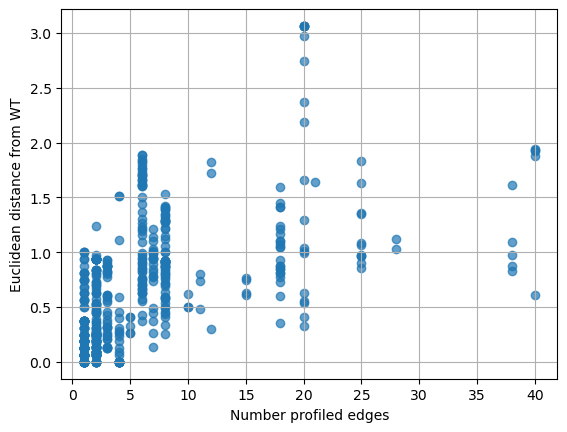

In [10]:
# see if there's a correlation between distance and number of edges
plt.scatter(orf_distances['num_edges'], orf_distances['euclid_distance'], alpha=0.7)
plt.ylabel('Euclidean distance from WT')
plt.xlabel('Number profiled edges')
plt.grid(True)
plt.show()

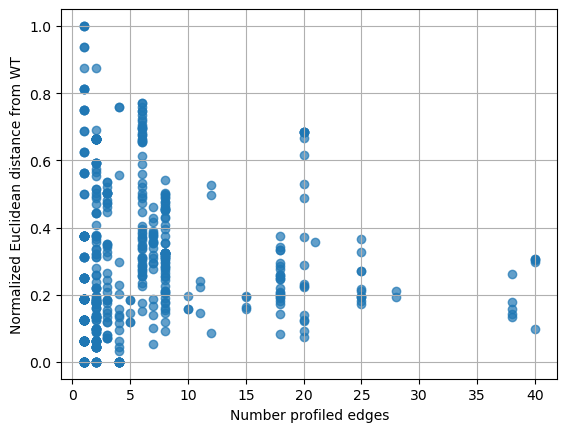

In [12]:
plt.scatter(orf_distances['num_edges'], orf_distances['normalized_euclid_distance'], alpha=0.7)
plt.ylabel('Normalized Euclidean distance from WT')
plt.xlabel('Number profiled edges')
plt.grid(True)
plt.show()

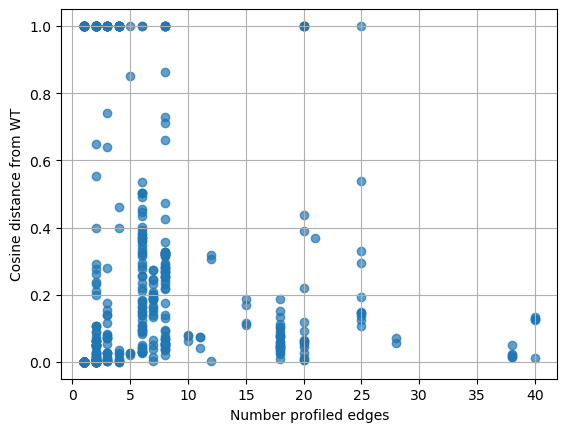

In [13]:
plt.scatter(orf_distances['num_edges'], orf_distances['cosine_distance'], alpha=0.7)
plt.ylabel('Cosine distance from WT')
plt.xlabel('Number profiled edges')
plt.grid(True)
plt.show()

In [21]:
orf_distances

db_orf_id,db_mut_id,euclid_distance,cosine_distance,num_edges,num_zero_wt,num_per_0.0,num_per_0.1,num_per_0.2,num_per_0.3,num_per_0.4,num_per_0.5,num_edge_0.0,num_edge_0.1,num_edge_0.2,num_edge_0.3,num_edge_0.4,num_edge_0.5,frac_per_0.0,frac_per_0.1,frac_per_0.2,frac_per_0.3,frac_per_0.4,frac_per_0.5,normalized_euclid_distance,symbol,aa_change,nt_change,ensembl_gene_id,collection,clinvar_clnsig_clean,gnomad_af,StarStatus,allele_0
str,str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,f64,f64,str
"""8999""","""203015""",0.0,0.0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0.0,0.0,0.0,0.0,null,null,0.0,"""TTR""","""Ala129Val""","""386C>T""","""ENSG00000118271""","""CEGS2""","""4_VUS""",0.00001,2.0,"""TTR_Ala129Val"""
"""8999""","""202979""",0.0625,0.0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0.0,0.0,0.0,0.0,null,null,0.0625,"""TTR""","""Phe53Ile""","""157T>A""","""ENSG00000118271""","""CEGS2""","""1_Pathogenic""",null,null,"""TTR_Phe53Ile"""
"""8999""","""203002""",0.1875,0.0,1,0,1,1,1,1,0,0,1,1,1,1,0,0,1.0,1.0,1.0,1.0,null,null,0.1875,"""TTR""","""Leu75Pro""","""224T>C""","""ENSG00000118271""","""CEGS2""","""1_Pathogenic""",null,null,"""TTR_Leu75Pro"""
"""8999""","""202976""",0.375,1.0,1,0,1,1,1,1,0,0,1,1,1,1,0,0,1.0,1.0,1.0,1.0,null,null,0.375,"""TTR""","""Ala45Thr""","""133G>A""","""ENSG00000118271""","""CEGS2""","""1_Pathogenic""",0.0,null,"""TTR_Ala45Thr"""
"""8999""","""203003""",0.125,0.0,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0.0,0.0,0.0,0.0,null,null,0.125,"""TTR""","""Glu109Gln""","""325G>C""","""ENSG00000118271""","""CEGS2""","""1_Pathogenic""",null,2.0,"""TTR_Glu109Gln"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""71077""","""220314""",0.1875,0.010414,4,0,0,0,0,0,0,0,4,4,4,4,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.09375,"""IMPDH1""","""Val317Ile""","""949G>A""","""ENSG00000106348""","""RC4""","""4_VUS""",null,1.0,"""IMPDH1_Val317Ile"""
"""9905""","""216952""",1.638168,0.369247,21,7,7,7,6,6,4,1,14,14,13,13,10,7,0.5,0.5,0.461538,0.461538,0.4,0.142857,0.357478,"""PNKP""","""Glu326Lys""","""976G>A""","""ENSG00000039650""","""CEGS2""","""1_Pathogenic""",null,2.0,"""PNKP_Glu326Lys"""
"""14468""","""218332""",0.0,0.0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""TPK1""","""Asn50His""","""148A>C""","""ENSG00000196511""","""CEGS2""","""1_Pathogenic""",null,null,"""TPK1_Asn50His"""


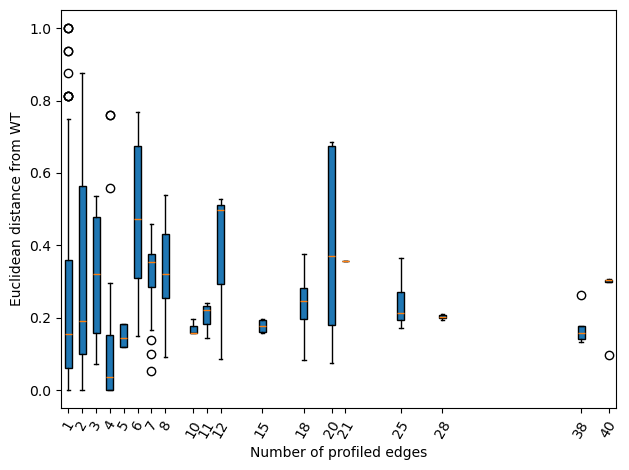

In [25]:
# make distributions more visible
grouped = orf_distances.to_pandas().groupby("num_edges")["normalized_euclid_distance"].apply(list)
boxplot_data = [grouped[k] for k in sorted(grouped.keys())]
xticks = sorted(grouped.keys())

plt.boxplot(boxplot_data, positions=xticks, patch_artist=True)
plt.xlabel("Number of profiled edges")
plt.ylabel("Euclidean distance from WT")
plt.grid(False)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

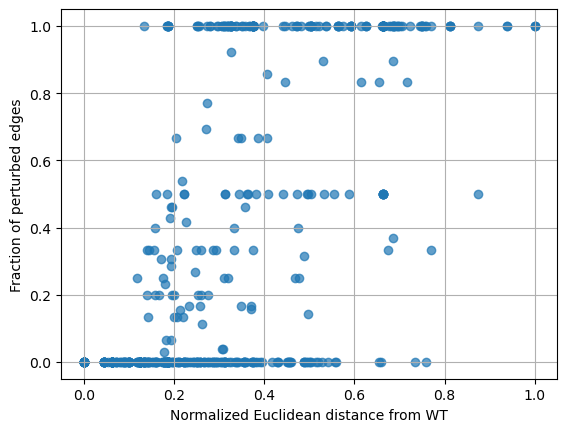

In [17]:
plt.scatter(orf_distances['normalized_euclid_distance'], orf_distances['frac_per_0.3'], alpha=0.7)
plt.ylabel('Fraction of perturbed edges')
plt.xlabel('Normalized Euclidean distance from WT')
plt.grid(True)
plt.show()

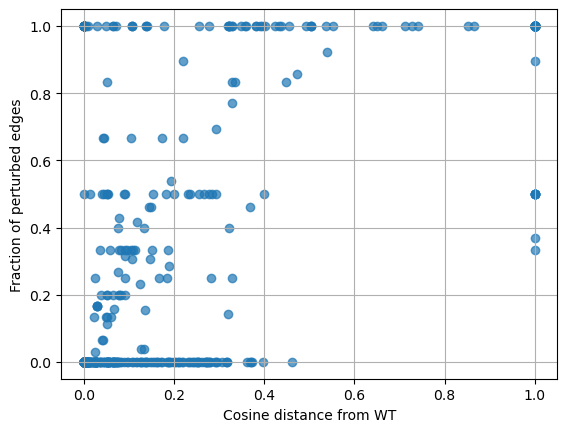

In [18]:
plt.scatter(orf_distances['cosine_distance'], orf_distances['frac_per_0.3'], alpha=0.7)
plt.ylabel('Fraction of perturbed edges')
plt.xlabel('Cosine distance from WT')
plt.grid(True)
plt.show()

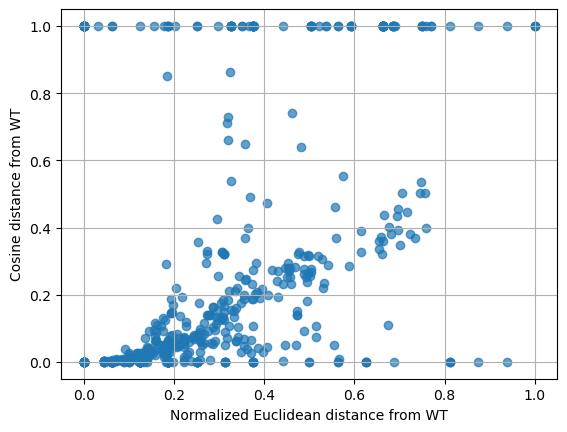

In [19]:
plt.scatter(orf_distances['normalized_euclid_distance'], orf_distances['cosine_distance'], alpha=0.7)
plt.ylabel('Cosine distance from WT')
plt.xlabel('Normalized Euclidean distance from WT')
plt.grid(True)
plt.show()

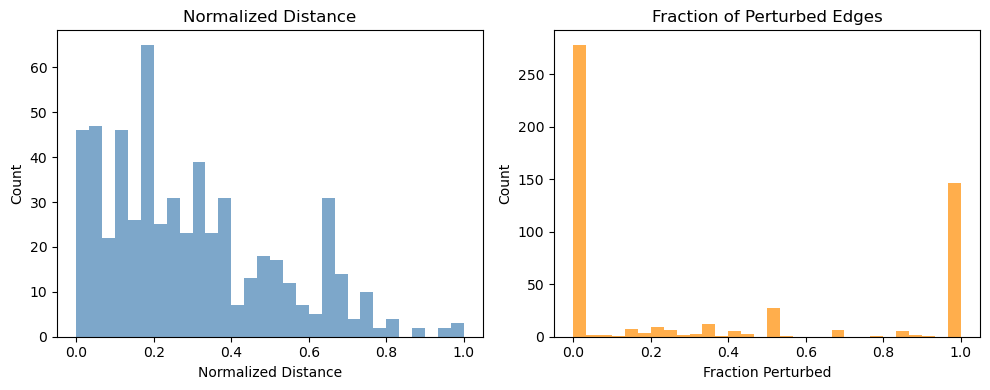

In [20]:

x = orf_distances['normalized_euclid_distance']
y = orf_distances['frac_per_0.3']

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(x, bins=30, color='steelblue', alpha=0.7)
axs[0].set_title("Normalized Distance")
axs[0].set_xlabel("Normalized Distance")
axs[0].set_ylabel("Count")

axs[1].hist(y, bins=30, color='darkorange', alpha=0.7)
axs[1].set_title("Fraction of Perturbed Edges")
axs[1].set_xlabel("Fraction Perturbed")
axs[1].set_ylabel("Count")

plt.tight_layout()
plt.show()